# 3D Group Brain Registration Using pirt

This notebook implements 3D group registration for brain images from the MouseCity3 dataset using the pirt library with DiffeomorphicDemonsRegistration.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pirt
import tifffile
from pathlib import Path
from skimage import io, transform, exposure
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [ ]:
# Data directory
data_dir = Path('/nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/')

# Registration settings
registration_settings = {
    'grid_sampling_factor': 1,  # The grid sampling of the grid at the final level
    'scale_sampling': 20,       # The amount of iterations for each level
    'speed_factor': 2,          # The relative force of the transform
    'downscale_factor': 0.25,    # Downscale images to speed up registration (use smaller value for 3D)
    'slice_count': None,          # Number of slices to use from 3D volume (None for all slices)
    'enhance_contrast': False,  # Whether to enhance contrast of the image
}

## Find all brain images

In [3]:
def find_brain_images(data_dir):
    """Find all ch0.tif files in the data directory
    
    Args:
        data_dir (Path): Path to the data directory
        
    Returns:
        dict: Dictionary mapping animal IDs to file paths
    """
    brain_images = {}
    
    # List all animal directories
    for animal_dir in data_dir.glob('ANM*'):
        if animal_dir.is_dir():
            # Check if itk/ch0.tif exists
            ch0_file = animal_dir / 'itk' / 'ch0.tif'
            if ch0_file.exists():
                animal_id = animal_dir.name
                brain_images[animal_id] = ch0_file
    
    return brain_images

# Find all brain images
brain_images = find_brain_images(data_dir)
print(f"Found {len(brain_images)} brain images:")
for animal_id, file_path in brain_images.items():
    print(f"  {animal_id}: {file_path}")

Found 6 brain images:
  ANM555974: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555974/itk/ch0.tif
  ANM555975: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555975/itk/ch0.tif
  ANM555976: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555976/itk/ch0.tif
  ANM556543: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556543/itk/ch0.tif
  ANM556544: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556544/itk/ch0.tif
  ANM556545: /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556545/itk/ch0.tif


## Load and preprocess 3D images

In [ ]:
def load_and_preprocess_image(file_path, downscale_factor=0.2, slice_count=None, enhance_contrast=False):
    """Load and preprocess a 3D brain image
    
    Args:
        file_path (Path): Path to the image file
        downscale_factor (float): Factor to downscale the image
        slice_count (int): Number of slices to use from 3D volume (None for all slices)
        
    Returns:
        np.ndarray: Preprocessed image (3D volume)
    """
    # Load image
    print(f"Loading {file_path}...")
    img = tifffile.imread(file_path)
    
    # Get image info
    print(f"  Original shape: {img.shape}, dtype: {img.dtype}")
    
    # Ensure we have a 3D image
    if len(img.shape) != 3:
        raise ValueError(f"Expected a 3D image, got shape {img.shape}")
    
    # Select a subset of slices if requested (for faster processing)
    if slice_count is not None and slice_count < img.shape[0]:
        # Take evenly spaced slices from the volume
        indices = np.linspace(0, img.shape[0]-1, slice_count).astype(int)
        img = img[indices]
        print(f"  Selected {slice_count} slices, new shape: {img.shape}")
    
    # Rescale to 0-1 float
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min())
    
    # Downscale if needed (this is crucial for 3D registration to be computationally feasible)
    if downscale_factor < 1.0:
        # Calculate new shape, preserving 3D structure
        new_shape = (int(img.shape[0] * downscale_factor), 
                     int(img.shape[1] * downscale_factor), 
                     int(img.shape[2] * downscale_factor))
        img = transform.resize(img, new_shape, anti_aliasing=True, preserve_range=True)
        print(f"  Downscaled to: {img.shape}")
    
    # Enhance contrast (slice by slice)
    if enhance_contrast:
        for i in range(img.shape[0]):
            img[i] = exposure.equalize_adapthist(img[i])
        print(f"  Enhanced contrast for {img.shape[0]} slices")

    return img

# Load a sample image to check
if brain_images:
    sample_id = list(brain_images.keys())[0]
    sample_img = load_and_preprocess_image(brain_images[sample_id], 
                                          registration_settings['downscale_factor'],
                                          registration_settings['slice_count'],
                                          registration_settings['enhance_contrast'])

    # Display middle slice of the 3D volume
    middle_slice = sample_img.shape[0] // 2
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_img[middle_slice], cmap='gray')
    plt.title(f"Sample image: {sample_id}, slice {middle_slice}/{sample_img.shape[0]}")
    plt.colorbar()
    plt.show()
    
    # Show a montage of multiple slices
    slice_indices = np.linspace(0, sample_img.shape[0]-1, min(9, sample_img.shape[0])).astype(int)
    plt.figure(figsize=(15, 15))
    for i, slice_idx in enumerate(slice_indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_img[slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No brain images found!")

## Load all brain images

In [10]:
def load_all_brain_images(brain_images, downscale_factor, slice_count=None, enhance_contrast=False):
    """Load all brain images
    
    Args:
        brain_images (dict): Dictionary mapping animal IDs to file paths
        downscale_factor (float): Factor to downscale the images
        slice_count (int): Number of slices to use from 3D volume (None for all slices)
        
    Returns:
        dict: Dictionary mapping animal IDs to preprocessed images
    """
    loaded_images = {}
    
    for animal_id, file_path in tqdm(brain_images.items(), desc="Loading images"):
        loaded_images[animal_id] = load_and_preprocess_image(file_path, downscale_factor, slice_count)
    
    return loaded_images

# Load all brain images
loaded_images = load_all_brain_images(brain_images, 
                                     registration_settings['downscale_factor'],
                                     registration_settings['slice_count'],
                                     registration_settings['enhance_contrast'])

Loading images:   0%|          | 0/6 [00:00<?, ?it/s]

Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555974/itk/ch0.tif...
  Original shape: (800, 1320, 658), dtype: uint16
  Downscaled to: (200, 330, 164)
Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555975/itk/ch0.tif...
  Original shape: (800, 1320, 658), dtype: uint16
  Downscaled to: (200, 330, 164)
Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM555976/itk/ch0.tif...
  Original shape: (800, 1320, 658), dtype: uint16
  Downscaled to: (200, 330, 164)
Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556543/itk/ch0.tif...
  Original shape: (800, 1320, 658), dtype: uint16
  Downscaled to: (200, 330, 164)
Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556544/itk/ch0.tif...
  Original shape: (800, 1320, 658), dtype: uint16
  Downscaled to: (200, 330, 164)
Loading /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ANM556545/itk/ch0.tif...
  Original shape: (800, 132

## Visualize all brain images

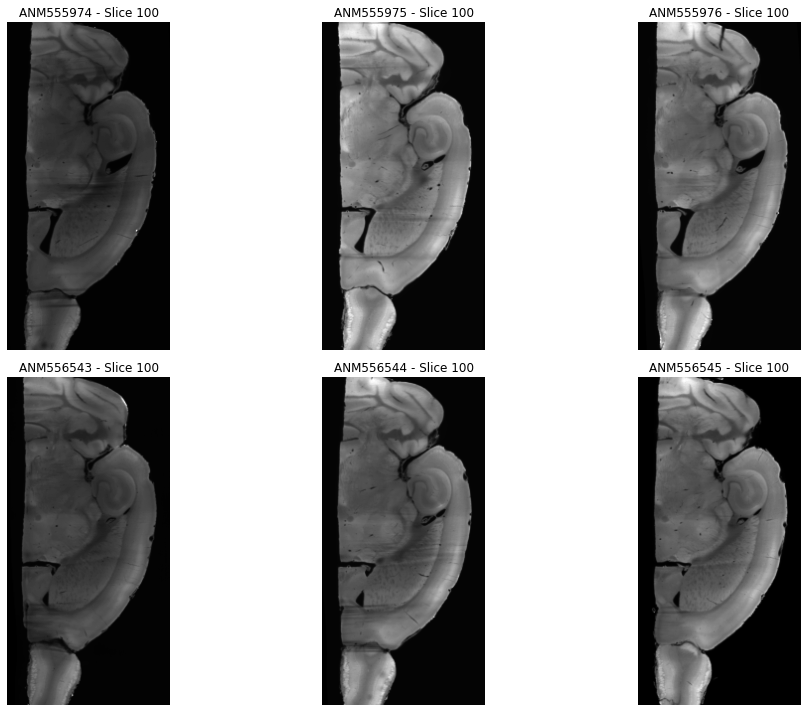

In [11]:
def visualize_brain_images(loaded_images, slice_idx=None):
    """Visualize all brain images
    
    Args:
        loaded_images (dict): Dictionary mapping animal IDs to preprocessed images
        slice_idx (int): Index of slice to display (None for middle slice)
    """
    num_images = len(loaded_images)
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols
    
    # Use middle slice if not specified
    if slice_idx is None:
        first_img = list(loaded_images.values())[0]
        slice_idx = first_img.shape[0] // 2
    
    plt.figure(figsize=(15, 5 * rows))
    
    for i, (animal_id, img) in enumerate(loaded_images.items()):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img[slice_idx], cmap='gray')
        plt.title(f"{animal_id} - Slice {slice_idx}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize all brain images (middle slice)
visualize_brain_images(loaded_images)

## Register 3D brain images using pirt

In [12]:
def register_brain_images(images, settings):
    """Register 3D brain images using pirt's DiffeomorphicDemonsRegistration
    
    Args:
        images (dict): Dictionary mapping animal IDs to preprocessed 3D images
        settings (dict): Registration settings
        
    Returns:
        tuple: (registration object, deformation fields, transformed images)
    """
    # Convert dictionary to list in a consistent order
    animal_ids = list(images.keys())
    image_list = [images[animal_id] for animal_id in animal_ids]
    
    # Create registration object - pirt can handle 3D volumes directly
    print(f"Registering {len(image_list)} 3D images with shapes: {[img.shape for img in image_list]}")
    reg = pirt.DiffeomorphicDemonsRegistration(*image_list)
    
    # Set registration parameters
    reg.params.grid_sampling_factor = settings['grid_sampling_factor']
    reg.params.scale_sampling = settings['scale_sampling']
    reg.params.speed_factor = settings['speed_factor']
    
    # Perform registration
    print("Starting registration - this may take a while for 3D volumes...")
    reg.register(verbose=1)
    print("Registration completed!")
    
    # Get deformation fields and transformed images
    deforms = []
    transformed_images = {}
    
    for i, animal_id in enumerate(animal_ids):
        print(f"Processing deformation for {animal_id}...")
        # Get deformation field
        deform = reg.get_deform(i)
        deforms.append(deform)
        
        # Transform image
        transformed = deform.apply_deformation(image_list[i])
        transformed_images[animal_id] = transformed
    
    return reg, deforms, transformed_images

# Register brain images
reg, deforms, transformed_images = register_brain_images(loaded_images, registration_settings)

Registering 6 3D images with shapes: [(200, 330, 164), (200, 330, 164), (200, 330, 164), (200, 330, 164), (200, 330, 164), (200, 330, 164)]
Starting registration - this may take a while for 3D volumes...
DiffeomorphicDemonsRegistration: 
iter 1, (6-1) scale 123.64
iter 2, (6-2) scale 119.43
iter 3, (6-3) scale 115.36
iter 4, (6-4) scale 111.43
iter 5, (6-5) scale 107.63
iter 6, (6-6) scale 103.97
iter 7, (6-7) scale 100.43
iter 8, (6-8) scale 97.01
iter 9, (6-9) scale 93.70
iter 10, (6-10) scale 90.51
iter 11, (6-11) scale 87.43
iter 12, (6-12) scale 84.45
iter 13, (6-13) scale 81.57
iter 14, (6-14) scale 78.79
iter 15, (6-15) scale 76.11
iter 16, (6-16) scale 73.52
iter 17, (6-17) scale 71.01
iter 18, (6-18) scale 68.59
iter 19, (6-19) scale 66.26
iter 20, (6-20) scale 64.00
iter 21, (5-1) scale 61.82
iter 22, (5-2) scale 59.71
iter 23, (5-3) scale 57.68
iter 24, (5-4) scale 55.72
iter 25, (5-5) scale 53.82
iter 26, (5-6) scale 51.98
iter 27, (5-7) scale 50.21
iter 28, 

## Visualize registration results

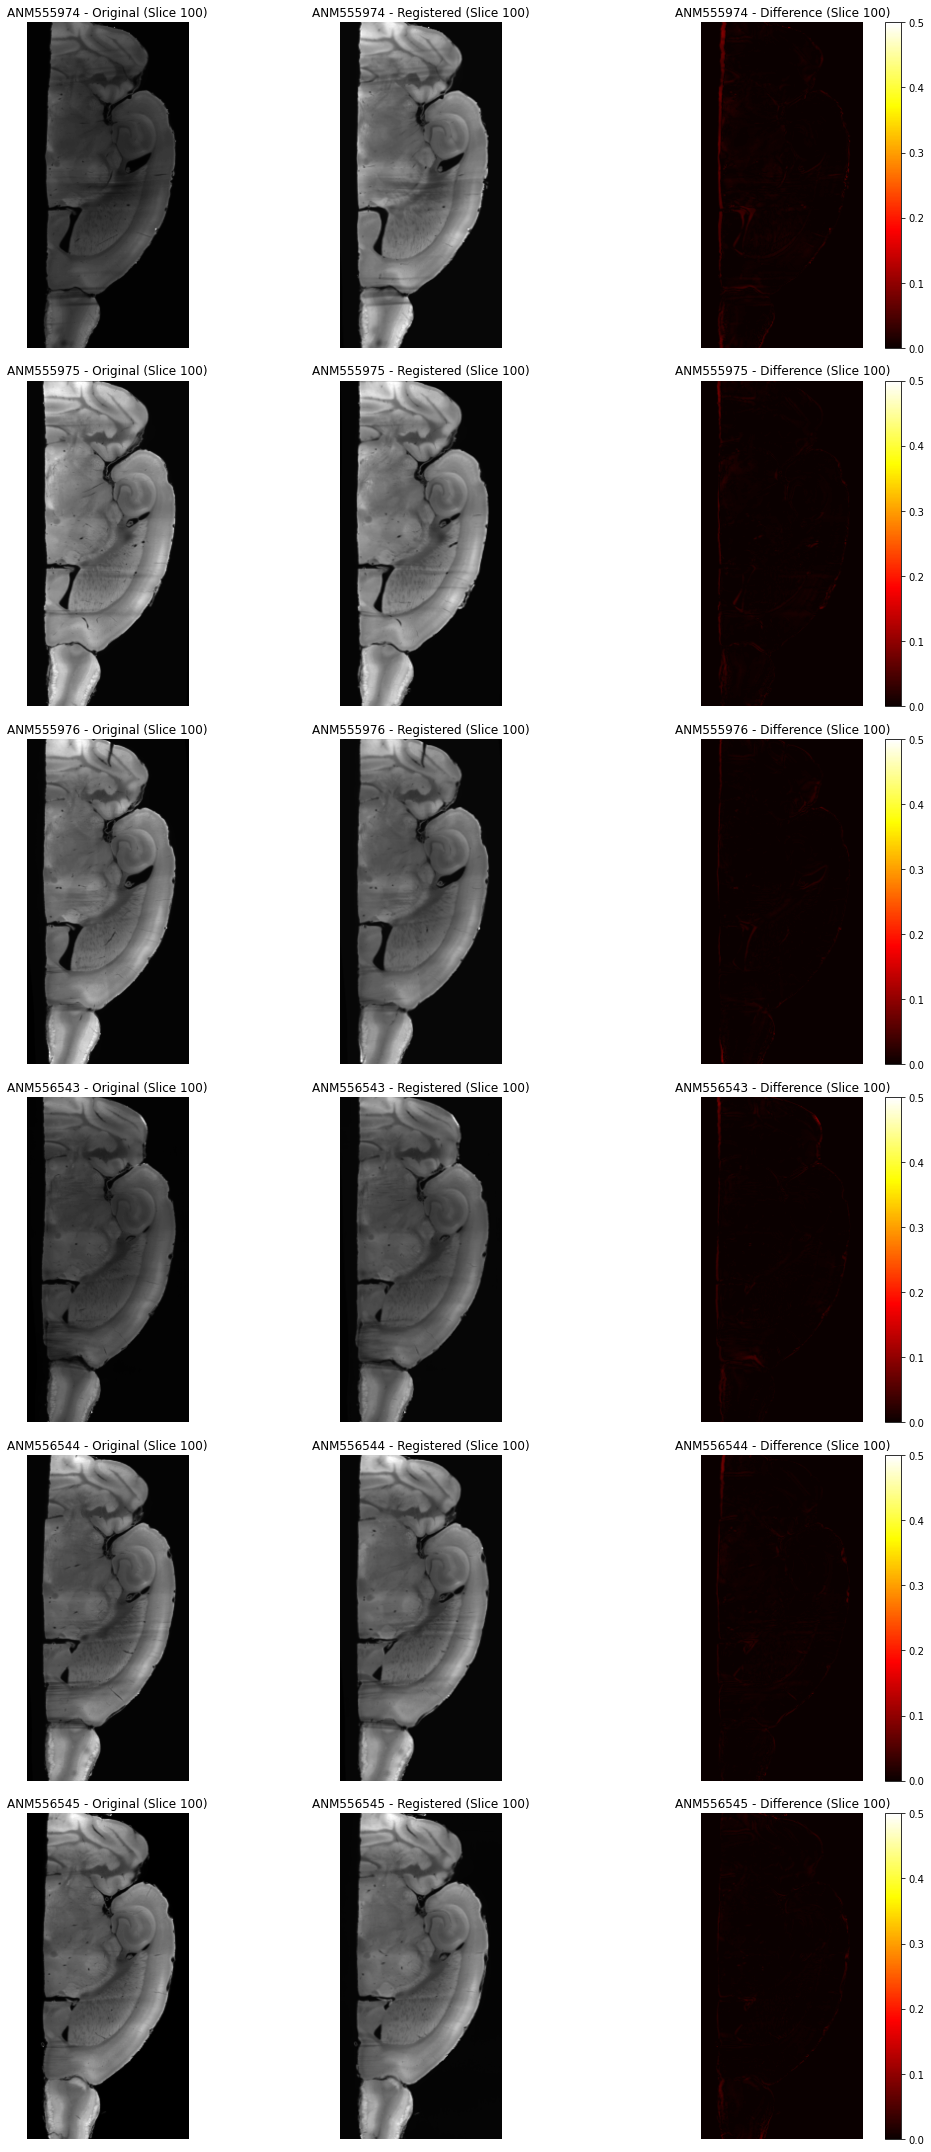

In [13]:
def visualize_registration_results(original_images, transformed_images, slice_idx=None):
    """Visualize registration results
    
    Args:
        original_images (dict): Dictionary mapping animal IDs to original 3D images
        transformed_images (dict): Dictionary mapping animal IDs to transformed 3D images
        slice_idx (int): Index of slice to display (None for middle slice)
    """
    num_images = len(original_images)
    animal_ids = list(original_images.keys())
    
    # Use middle slice if not specified
    if slice_idx is None:
        first_img = list(original_images.values())[0]
        slice_idx = first_img.shape[0] // 2
    
    plt.figure(figsize=(15, 5 * num_images))
    
    for i, animal_id in enumerate(animal_ids):
        # Original image
        plt.subplot(num_images, 3, i*3+1)
        plt.imshow(original_images[animal_id][slice_idx], cmap='gray')
        plt.title(f"{animal_id} - Original (Slice {slice_idx})")
        plt.axis('off')
        
        # Transformed image
        plt.subplot(num_images, 3, i*3+2)
        plt.imshow(transformed_images[animal_id][slice_idx], cmap='gray')
        plt.title(f"{animal_id} - Registered (Slice {slice_idx})")
        plt.axis('off')
        
        # Difference image
        plt.subplot(num_images, 3, i*3+3)
        diff = np.abs(original_images[animal_id][slice_idx] - transformed_images[animal_id][slice_idx])
        plt.imshow(diff, cmap='hot', vmin=0, vmax=0.5)
        plt.title(f"{animal_id} - Difference (Slice {slice_idx})")
        plt.axis('off')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Visualize registration results (middle slice)
visualize_registration_results(loaded_images, transformed_images)

# Try a few different slices
if registration_settings['slice_count']:
    for slice_idx in [0, registration_settings['slice_count']//4, registration_settings['slice_count']//2, 
                      3*registration_settings['slice_count']//4, registration_settings['slice_count']-1]:
        print(f"\nResults for slice {slice_idx}:")
        visualize_registration_results(loaded_images, transformed_images, slice_idx)

## Calculate average brain template

Template shape: (200, 330, 164)


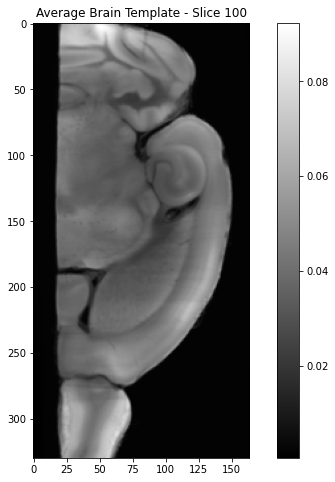

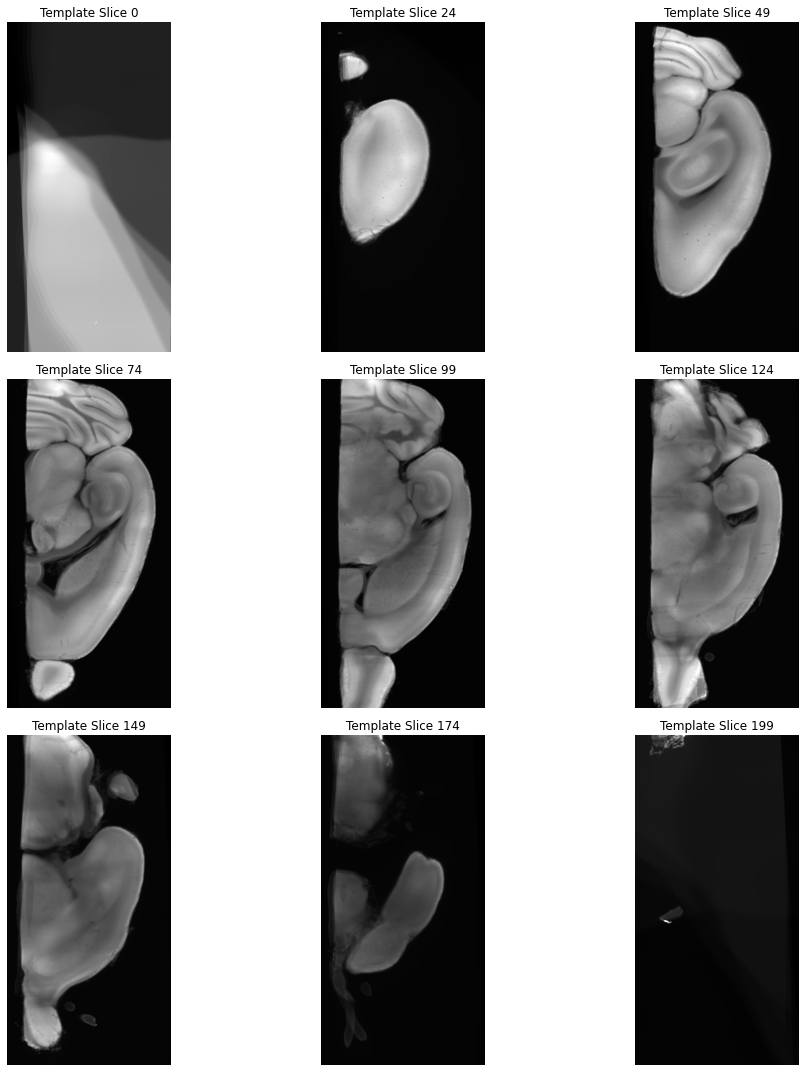

In [15]:
def calculate_average_template(transformed_images):
    """Calculate average brain template from registered 3D images
    
    Args:
        transformed_images (dict): Dictionary mapping animal IDs to transformed 3D images
        
    Returns:
        np.ndarray: Average brain template (3D volume)
    """
    # Stack all transformed images
    image_stack = [np.asarray(img) for img in transformed_images.values()]

    # Calculate average
    template = np.mean(np.stack(image_stack), axis=0)
    
    return template

# Calculate average template
template = calculate_average_template(transformed_images)
print(f"Template shape: {template.shape}")

# Display middle slice of the template
middle_slice = template.shape[0] // 2
plt.figure(figsize=(10, 8))
plt.imshow(template[middle_slice], cmap='gray')
plt.title(f"Average Brain Template - Slice {middle_slice}")
plt.colorbar()
plt.show()

# Show a montage of multiple template slices
slice_indices = np.linspace(0, template.shape[0]-1, min(9, template.shape[0])).astype(int)
plt.figure(figsize=(15, 15))
for i, slice_idx in enumerate(slice_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(template[slice_idx], cmap='gray')
    plt.title(f"Template Slice {slice_idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Save registration results

In [ ]:
def save_registration_results(transformed_images, template, deforms, animal_ids, output_dir):
    """Save registration results
    
    Args:
        transformed_images (dict): Dictionary mapping animal IDs to transformed 3D images
        template (np.ndarray): Average brain template (3D volume)
        deforms (list): List of deformation field objects
        animal_ids (list): List of animal IDs
        output_dir (Path): Path to the output directory
    """
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save template
    template_path = output_dir / 'template.tif'
    tifffile.imwrite(template_path, template)
    print(f"Saved template to {template_path}")
    
    # Save transformed images
    for animal_id, img in transformed_images.items():
        img_path = output_dir / f"{animal_id}_registered.tif"
        tifffile.imwrite(img_path, img)
        print(f"Saved {animal_id} to {img_path}")
    
    # Save deformation fields
    deform_dir = output_dir / 'deformation_fields'
    deform_dir.mkdir(exist_ok=True)
    
    for i, animal_id in enumerate(animal_ids):
        # For 3D images, save deformation fields for each dimension
        for dim in range(deforms[i].ndim):
            field = deforms[i].get_field(dim)
            np.save(deform_dir / f"{animal_id}_deform_dim{dim}.npy", field)
        print(f"Saved deformation fields for {animal_id}")

# Create output directory
output_dir = data_dir / Path('registration_results')
# Save registration results
save_registration_results(transformed_images, template, deforms, list(loaded_images.keys()), output_dir)

## Create Python script for batch processing

In [ ]:
python register_brains_3d_parallel.py \
    --data_dir /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/ \
    --output_dir /nearline/spruston/Boaz/DELTA/I2/20250111_IDISCO_MouseCity3/registration_results_param_scan \
    --grid_sampling_factors 1 2 \
    --scale_samplings 10 20 40 \
    --speed_factors 1 2 3 \
    --downscale 0.2 \
    --save_visualizations